**This notebook provides an examplory analysis of Flats for Sale.**

Even though the analysis is specific, the logic can be used to other categories as well. However, columns will differ.

**Note:** This notebook contains some data with czech names. We apologize for that inconvenience. This is due to the fact that the data are being scraped from the Czech website.

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import sqlite3
import seaborn as sns
from scipy import stats

### Loading data from SQLite:

In [170]:
path_to_sqlite='estate_data.sqlite'
con = sqlite3.connect(path_to_sqlite)

In [171]:
print("Tables in our database:\n")
cursor = con.cursor()
# Getting all tables from sqlite_master
sql_query = """SELECT name FROM sqlite_master WHERE type='table';"""
cursor.execute(sql_query)
sqlite_tables = cursor.fetchall()
sqlite_tables = [*map(lambda table: table[0] ,sqlite_tables)]
print(sqlite_tables)
del sqlite_tables
del sql_query

Tables in our database:

['OFFERS_APARTMENTS_SALE', 'DESCRIPTION_TABLE']


In [172]:
df_description = pd.read_sql('SELECT * FROM DESCRIPTION_TABLE', con = con)

In [173]:
df_offers = pd.read_sql('SELECT * FROM OFFERS_APARTMENTS_SALE', con = con)

In [174]:
df_offers.shape, df_description.shape

((22140, 21), (22071, 35))

Note: df_offers has more rows as some offers disappeared before description download was finished.

In [175]:
# Closing the connection
con.close()

### Data types:

In [176]:
df_offers.dtypes

hash_id                 int64
price                   int64
price_czk               int64
price_czk_unit         object
price_czk_name         object
area                    int64
lat                   float64
lon                   float64
locality               object
flat_type              object
type                    int64
category                int64
is_auction              int64
exclusively_at_rk       int64
category_main           int64
category_sub            int64
category_type           int64
company_id            float64
company_name           object
date_download          object
locality_region_id      int64
dtype: object

In [177]:
df_description.dtypes

hash_id                           object
description                       object
discounted                        object
date_update                       object
building_type                     object
building_condition                object
building_location                 object
area_net                          object
area_floor                        object
price_total                       object
price_note                        object
transport                         object
area_build_up                     object
equipped                          object
electricity                       object
traffic_communication             object
barrier_free                     float64
energy_efficient_rating           object
lift                             float64
building_floor_type               object
building_floor                    object
water                             object
gas                               object
waste                             object
heating         

We must correctly convert data types of df_description.

In [178]:
# Columns which have spaces between numbers
columns_to_transform = ["price_total", "discounted"]
for col in columns_to_transform:
    # 1.
    df_description[col].replace(np.nan, "None", inplace=True)
    # 2.
    df_description[col] = df_description[col].apply(lambda x: x.replace("\xa0", ""))
    # 3.
    df_description[col].replace("None", np.nan, inplace=True)

del columns_to_transform

'energy_efficient_rating_index' has "," instead of "." which needs to be tackle before can be converted to float

In [179]:
def repl(value):
    if value != None:
        return value.replace(",", ".")

df_description["energy_efficient_rating_index"] = df_description["energy_efficient_rating_index"].apply(lambda row: repl(row))

In [180]:
# Convert to correct data types - we usually use float64 instead of int64 to keep NaN
settings = {"hash_id" : np.int64,
            "discounted" : np.float64,
            "area_net" : np.float64,
            "area_floor" : np.float64,
            "price_total" : np.float64,
            "area_build_up" : np.float64,
            "area_garden" : np.float64,
            "energy_efficient_rating_index" : np.float64,
            "lift" : object,
            "barrier_free" : object   
}

df_description = df_description.astype(settings)
del settings

In [181]:
# Checking
df_description.dtypes

hash_id                            int64
description                       object
discounted                       float64
date_update                       object
building_type                     object
building_condition                object
building_location                 object
area_net                         float64
area_floor                       float64
price_total                      float64
price_note                        object
transport                         object
area_build_up                    float64
equipped                          object
electricity                       object
traffic_communication             object
barrier_free                      object
energy_efficient_rating           object
lift                              object
building_floor_type               object
building_floor                    object
water                             object
gas                               object
waste                             object
heating         

### Joining:

We join these 2 tables as their have both 'hash_id' column.

In [182]:
df = df_description.merge(df_offers, on = "hash_id", how = "inner")

In [183]:
df.shape

(22071, 55)

In [184]:
# We do not need those anymore
del df_offers
del df_description

**Note that we are using data extracted during one day in 2023-02-05:**

In [185]:
print(df["date_download"].nunique(), "\n")
print(df["date_download"].value_counts())

1 

2023-02-05    22071
Name: date_download, dtype: int64


In [186]:
df.columns

Index(['hash_id', 'description', 'discounted', 'date_update', 'building_type',
       'building_condition', 'building_location', 'area_net', 'area_floor',
       'price_total', 'price_note', 'transport', 'area_build_up', 'equipped',
       'electricity', 'traffic_communication', 'barrier_free',
       'energy_efficient_rating', 'lift', 'building_floor_type',
       'building_floor', 'water', 'gas', 'waste', 'heating',
       'telecommunication', 'energy_efficient_rating_card', 'availability',
       'energy_efficient_rating_index', 'area_garden', 'parking', 'garage',
       'ownership', 'cellar', 'balcony', 'price', 'price_czk',
       'price_czk_unit', 'price_czk_name', 'area', 'lat', 'lon', 'locality',
       'flat_type', 'type', 'category', 'is_auction', 'exclusively_at_rk',
       'category_main', 'category_sub', 'category_type', 'company_id',
       'company_name', 'date_download', 'locality_region_id'],
      dtype='object')

### Dropping columns - 1st stage:

**Note that some scrapped values in df_offers are wrong! --> No problem, we have its correct equivalents from df_description!**

Price column - multiple options

In [187]:
df[df.columns[df.columns.str.contains("price")]]   # price_total column is correct (we checked the reality on the website) so we simply drop columns gained from df_offers

,price_total,price_note,price,price_czk,price_czk_unit,price_czk_name
0,11500000.0,None,7662000,7662000,,Celková cena
1,NaN,cena u makléře,0,0,,Celková cena
2,1780000.0,None,1869000,1869000,,Celková cena
3,3900000.0,None,2598000,2598000,,Celková cena
4,1599000.0,"včetně DPH, včetně poplatků, včetně provize, v...",1065000,1065000,,Celková cena
...,...,...,...,...,...,...
22066,993600.0,V případě více zájemců může RK využít pro výbě...,498000,498000,,Celková cena
22067,1999990.0,None,1003000,1003000,,Celková cena
22068,8610000.0,"v ceně sklepní kóje, parkovací stání, moderní ...",4319000,4319000,,Celková cena
22069,5546700.0,Včetně realitního servisu,2782000,2782000,,Celková cena


Area

In [188]:
df[df.columns[df.columns.str.contains("area")]] # Again, "area" gained from df_offers is wrong (according to the website)so we drop it.

,area_net,area_floor,area_build_up,area_garden,area
0,132.0,NaN,NaN,NaN,87
1,47.0,47.0,NaN,NaN,49
2,72.0,72.0,NaN,NaN,75
3,72.0,72.0,NaN,NaN,47
4,45.0,NaN,NaN,NaN,29
...,...,...,...,...,...
22066,31.0,NaN,NaN,NaN,15
22067,40.0,37.0,NaN,NaN,20
22068,101.0,94.0,NaN,NaN,50
22069,88.0,88.0,NaN,NaN,44


We also drop:
- 'building_floor_type' as it has only NaN
- 'energy_efficient_rating_card' as it has no useful information
- 'type', 'is_auction' as these are the same as 'category_type'
- 'category' as it is the same as 'category_main'

In [189]:
# Drop columns, we do not care about 
columns_to_drop = ['price',
                   'price_czk',
                   'price_czk_name',
                   'price_czk_unit',
                   'area',
                   'building_floor_type',
                   'energy_efficient_rating_card',
                   'type',
                   'category',
                   'is_auction'
                   ]

df.drop(columns_to_drop, axis=1, inplace= True)
del columns_to_drop

### Cleaning columns:

Lists in cells cannot be saved into SQLite so we used the trick to save them as a string seperated by double space.

In [190]:
# Transform them back to lists
columns_w_mult_values = ["transport", "electricity", "telecommunication"]

def transformer(value):
    if value != None:
        return value.split("  ")

for column in columns_w_mult_values:
        df[column] = df[column].apply(lambda row: transformer(row))

In [191]:
df[columns_w_mult_values]

,transport,electricity,telecommunication
0,"[Silnice, MHD, Autobus]",None,None
1,None,None,None
2,"[Vlak, Silnice, MHD, Autobus]",[230V],"[Internet, Kabelová televize, Kabelové rozvody]"
3,None,None,None
4,"[Vlak, Dálnice, Silnice, MHD, Autobus]",[230V],[Ostatní]
...,...,...,...
22066,"[Silnice, MHD, Autobus]","[120V, 230V]",[Kabelová televize]
22067,None,[230V],None
22068,"[Vlak, Dálnice, Silnice, Autobus]",[230V],"[Internet, Kabelová televize]"
22069,"[Vlak, Silnice, Autobus]",[230V],"[Telefon, Internet, Kabelové rozvody]"


In [192]:
possible_values = {"transport" : ["Vlak", "Dálnice", "Silnice", "MHD", "Autobus"],
                   "electricity" : ["230V", "400V", "120V"],
                   "telecommunication" : ["Internet", "Telefon", "Kabelové rozvody", "Satelit", "Kabelová televize"] # "Ostatní"
                    }

def transformer(value):
    if value != None:
        if y in value:
            return True
        else:
            return False

for i in possible_values:
    for y in possible_values[i]:
        df[y] = df[i].apply(lambda row: transformer(row))

del columns_w_mult_values
del possible_values

### Dropping columns - 2nd stage:

In [193]:
# Drop columns, we do not care about 
columns_to_drop = ['transport',
                   'electricity',
                   'telecommunication'
                   ]

df.drop(columns_to_drop, axis=1, inplace= True)
del columns_to_drop

Next we transform columns:
- 'barrier_free', 'lift' - if 1: assign true; if 0: assign false
- 'equipped'- if ano: assign true; if ne: assign false
- 'balcony', 'cellar' - if 1: assign true
- 'garage', 'parking' - if not NaN: assign true
- 'locality_region_id' - assign name of the region
- 'energy_efficient_rating' - assign number which indicates the rating
- 'building_floor' -

Note: if value in columns 'balcony' and 'cellar' is > 1 then it corresponds to square meters.

In [194]:
columns = ["lift", "barrier_free"]
for col in columns:
    df[col].replace(1, "true", inplace = True)
    df[col].replace(0, "false", inplace = True)
del columns

In [195]:
# 'equipped'
df['equipped'].replace("ano", "true", inplace = True)
df['equipped'].replace("ne", "false", inplace = True)

In [196]:
df["balcony"].replace("1", "true", inplace = True)
df["cellar"].replace("1", "true", inplace = True)

In [197]:
# "garage", "parking"
def transformer(value):
    if value != None:
        return True
    
df["garage"] = df["garage"].apply(lambda row: transformer(row))
df["parking"] = df["parking"].apply(lambda row: transformer(row))     

**Note:** We aplogize for czech names of regions. You can translate below:
- Jihočeský kraj - South Bohemian Region
- Plzeňský kraj - Plzeň Region
- Karlovarský kraj - Karlovy Vary Region
- Ústecký kraj - Ústí nad Labem Region
- Liberecký kraj - Liberec Region
- Královéhradecký kraj - Hradec Králové Region
- Pardubický kraj - Pardubice Region
- Olomoucký kraj - Olomouc Region
- Zlínský kraj - Zlín Region
- Praha - Prague
- Středočeský kraj - Central Bohemian Region
- Moravskoslezský kraj - Moravian-Silesian Region
- Vysočina kraj - Vysočina Region
- Jihomoravský kraj - South Moravian Region

In [198]:
# "locality_region_id"

mapping = {1:"Jihočeský kraj",
           2:"Plzeňský kraj",
           3:"Karlovarský kraj",
           4:"Ústecký kraj",
           5:"Liberecký kraj",
           6:"Královéhradecký kraj",
           7:"Pardubický kraj",
           8:"Olomoucký kraj",
           9:"Zlínský kraj",
           10:"Praha",
           11:"Středočeský kraj",
           12:"Moravskoslezský kraj",
           13:"Vysočina kraj",
           14:"Jihomoravský kraj"
           }

df["locality_region_id"].replace(mapping, inplace = True)
del mapping

In [199]:
# We rename the column
df.rename(columns={'locality_region_id': 'region'}, inplace = True)

In [200]:
# 'energy_efficient_rating'
def transformer(value):
    if value != None:
        return value.split()[1]
df['energy_efficient_rating'] = df['energy_efficient_rating'].apply(lambda row: transformer(row))
df['energy_efficient_rating'].value_counts()

G    9188
B    4272
C    3735
D    1456
E     441
A     282
F     155
Name: energy_efficient_rating, dtype: int64

In [201]:
# "building_floor" --> This is very manual approach --> there is a space for improvement.
def transformer(value):
    if (value != None) & (len(value.split()[0]) <= 3):
        if len(value.split()[0]) == 2:
            return value.split()[0][0]
        if len(value.split()[0]) == 3:
            return value.split()[0][:2]
    if value.split()[0] == "přízemí":
        return 0 # keep Nan!!!

df["floor"] = df["building_floor"].apply(lambda row: transformer(row))

In [202]:
df["floor"].value_counts().sort_values(ascending = False)

2     5146
1     4703
3     4092
4     3006
5     1758
6     1153
7      801
8      551
9      232
10     152
11     132
12      96
0       93
-1      57
13      54
14      22
15       9
-2       5
17       1
20       1
24       1
18       1
19       1
82       1
16       1
28       1
Name: floor, dtype: int64

In [203]:
df["floor"].dtype

dtype('O')

We keep column 'building_floor' as there is additional info.

In [204]:
# Our final 'clean' df
df

,hash_id,description,discounted,date_update,building_type,building_condition,building_location,area_net,area_floor,price_total,...,Autobus,230V,400V,120V,Internet,Telefon,Kabelové rozvody,Satelit,Kabelová televize,floor
0,261724,Nabizíme Vám na prodej exkluzivní mezonetový b...,NaN,05.01.2023,Smíšená,Velmi dobrý,None,132.0,NaN,11500000.0,...,True,None,None,None,None,None,None,None,None,2
1,571212,Nabízíme moderní byt 2+kk v klidové zóně se sn...,NaN,12.01.2023,Smíšená,V rekonstrukci,Klidná část obce,47.0,47.0,NaN,...,None,None,None,None,None,None,None,None,None,2
2,726604,Představujeme k prodeji bytovou jednotku o vel...,NaN,13.01.2023,Panelová,Velmi dobrý,None,72.0,72.0,1780000.0,...,True,True,False,False,True,False,True,False,True,4
3,1168460,Nabízíme k prodeji investiční nabídku v těsné...,NaN,20.01.2023,Cihlová,Dobrý,Centrum obce,72.0,72.0,3900000.0,...,None,None,None,None,None,None,None,None,None,1
4,1427276,Nabízíme k prodeji podkrovní byt v osobním vla...,NaN,17.01.2023,Cihlová,Dobrý,Centrum obce,45.0,NaN,1599000.0,...,True,True,False,False,False,False,False,False,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22066,4289643596,"Nabízíme k prodeji, družstevní byt 1+kk, 31m2 ...",NaN,03.02.2023,Panelová,Dobrý,Klidná část obce,31.0,NaN,993600.0,...,True,True,False,True,False,False,False,False,True,4
22067,4291221068,Exkluzivně Vám nabízím byt 1+1 s balkonem v os...,NaN,30.01.2023,Panelová,Velmi dobrý,Centrum obce,40.0,37.0,1999990.0,...,None,True,False,False,None,None,None,None,None,2
22068,4291942492,"Nabízíme Vám byt 3+kk, podlahová plocha 94,2 m...",NaN,22.11.2022,Cihlová,Ve výstavbě,Klidná část obce,101.0,94.0,8610000.0,...,True,True,False,False,True,False,False,False,True,1
22069,4293637196,Exkluzivně nabízíme moderní nadstandardní byt ...,NaN,31.01.2023,Cihlová,Novostavba,Centrum obce,88.0,88.0,5546700.0,...,True,True,False,False,True,True,True,False,False,2


Once we have all columns trasformed, we can save df to SQLite.

In [205]:
#path_to_sqlite='estate_data.sqlite'
#con = sqlite3.connect(path_to_sqlite)
#df.to_sql(name = 'FINAL_TABLE', con= con, index = False)
#con.close()

Finally, we transformed all columns so we can continue with data processing...

## Data processing:

#### Remove mistake values:

We drop rows with 'category_type' other than equal to 1 as we want only estates **for sale**.

In [206]:
df = df[df.category_type == 1]

**For simplicity, we decided to drop columns we consider are 'not too important':** (If we did not, it would be too time costly to the analysis properly.)
- 'not too important' --> a lot of NaN or less informative

In [207]:
columns_to_drop = ['description',
                   'discounted',
                   'date_update',
                   'area_floor',
                   'price_note',
                   'area_build_up',
                   'traffic_communication',
                   'building_floor',
                   'availability',
                   'energy_efficient_rating_index',
                   'area_garden',
                   'company_id',
                   'company_name',                                   
                   ]
df.drop(columns_to_drop, axis=1, inplace= True)
del columns_to_drop

C:\Users\novot\AppData\Local\Temp/ipykernel_7792/1212705715.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns_to_drop, axis=1, inplace= True)


In [208]:
# We convert "floor" column to float
df = df.astype({"floor": np.float64})

In [209]:
qualitative = [column for column in df.columns if df.dtypes[column] == 'object']

quantitative = [column for column in df.columns if df.dtypes[column] != 'object']

print(qualitative,"\n")
print(quantitative)

['building_type', 'building_condition', 'building_location', 'equipped', 'barrier_free', 'energy_efficient_rating', 'lift', 'water', 'gas', 'waste', 'heating', 'parking', 'garage', 'ownership', 'cellar', 'balcony', 'locality', 'flat_type', 'date_download', 'region', 'Vlak', 'Dálnice', 'Silnice', 'MHD', 'Autobus', '230V', '400V', '120V', 'Internet', 'Telefon', 'Kabelové rozvody', 'Satelit', 'Kabelová televize'] 

['hash_id', 'area_net', 'price_total', 'lat', 'lon', 'exclusively_at_rk', 'category_main', 'category_sub', 'category_type', 'floor']


### Cleaning data

#### Duplicates:

In [210]:
df.shape

(22026, 43)

In [211]:
# Drop duplicates
df = df.drop_duplicates(subset="hash_id")

In [212]:
df.shape # there seems to be no duplicates

(22026, 43)

#### Outliers:

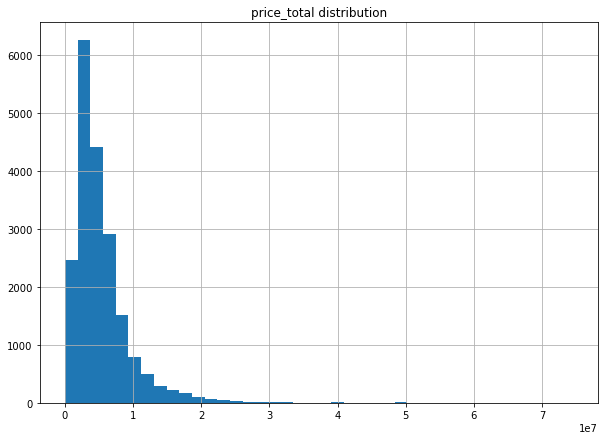

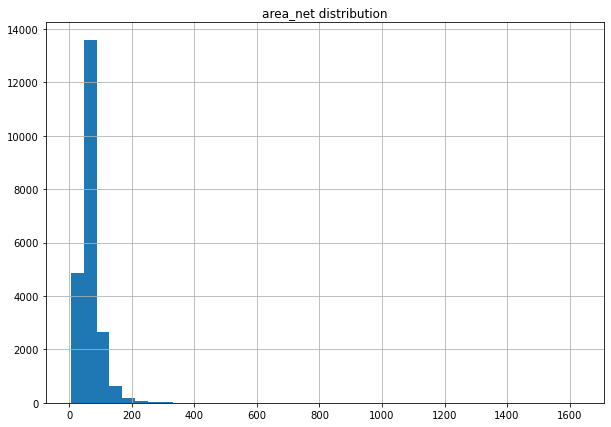

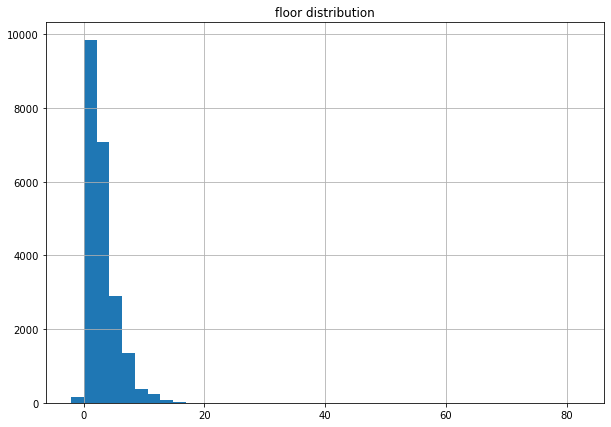

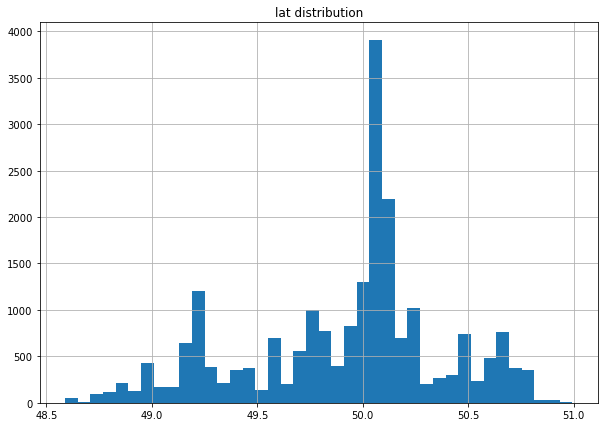

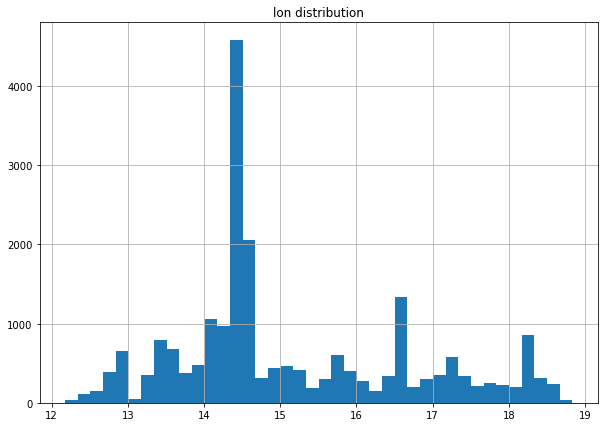

In [213]:
# Histograms:
columns = ["price_total", "area_net", "floor", "lat", "lon"]
for col in columns:
    plt.figure(figsize = (10,7))
    df[col].hist(bins=40)
    plt.title(col + " distribution")
    plt.show()
del columns

**According to "lat", "lon" values, we can check if all estates locale in the CR.**

There is no a golden rule to detect outliers. We choose the basic automated approach for 'price_total' and 'area_net'.

We could use IQR:

In [214]:
"""
columns = ["price_total", "area_net", "floor"]
for col in columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df = df.loc[(df[col] > fence_low) & (df[col] < fence_high)]
del columns
"""

'\ncolumns = ["price_total", "area_net", "floor"]\nfor col in columns:\n    q1 = df[col].quantile(0.25)\n    q3 = df[col].quantile(0.75)\n    iqr = q3-q1 #Interquartile range\n    fence_low  = q1-1.5*iqr\n    fence_high = q3+1.5*iqr\n    df = df.loc[(df[col] > fence_low) & (df[col] < fence_high)]\ndel columns\n'

In [215]:
df.shape

(22026, 43)

But we decided to drop outliers basec on 0.99 and 0.01 quantiles:

**We need to make sure to keep NaN values which will be tackled later.**

In [216]:
columns = ["price_total", "area_net"]
for col in columns:
    q_low = df[col].quantile(0.01)
    q_hi  = df[col].quantile(0.99)
    df = df[((df[col] < q_hi) & (df[col] > q_low)) | (df[col].isna())]
del columns

In [217]:
df.shape # Note that we have detected some outliers. 

(21120, 43)

In [218]:
# In addition, we will drop outliers of 'floor' column manually
# We drop rows which have 'floor' > 12 and 'floor' < 0 as too high buildings and buildings with negative floors could be considered outliers
df = df[((df["floor"] < 13) & (df["floor"] >= 0)) | (df["floor"].isna())]

In [219]:
df.shape # Some outliers also detected in 'floor' column

(20979, 43)

#### Missing values:

<AxesSubplot:>

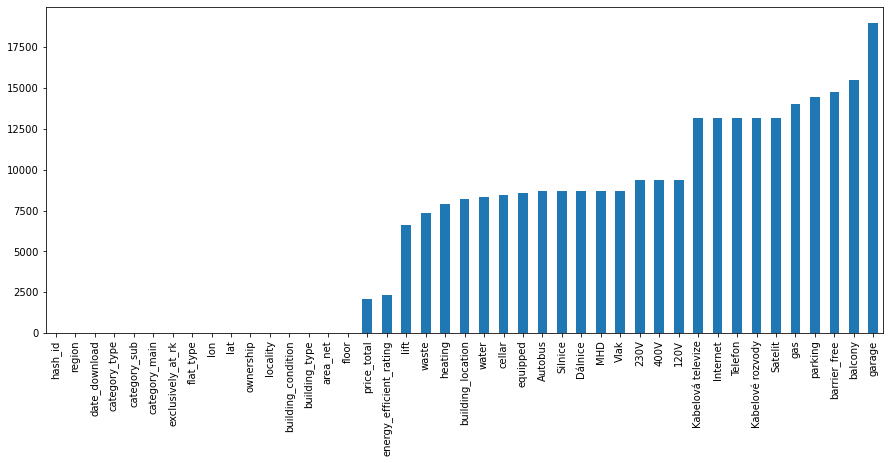

In [220]:
df.isna().sum().sort_values().plot.bar(figsize=(15, 6))

**We can see that a lot of columns have a big portion of rows missing. So we will simply drop them.**

Otherwise, if we would be insterested in these columns, we could drop or fill its missing rows. But we would lose a lot of observations. 

In [221]:
# Drop columns with a lot of NaN
columns_to_drop = ['garage',
                   'balcony',
                   'barrier_free',
                   'parking',
                   'gas',
                   'Satelit',
                   'Kabelové rozvody',
                   'Telefon',
                   'Internet',
                   'Kabelová televize',
                   '120V',
                   '400V',
                   '230V',
                   'Vlak',
                   'MHD',
                   'Dálnice',
                   'Silnice',
                   'Autobus',
                   'equipped',
                   'cellar',
                   'water',
                   'building_location',
                   'heating',
                   'waste',
                   'lift',
                   ]

df.drop(columns_to_drop, axis=1, inplace= True)
del columns_to_drop

<AxesSubplot:>

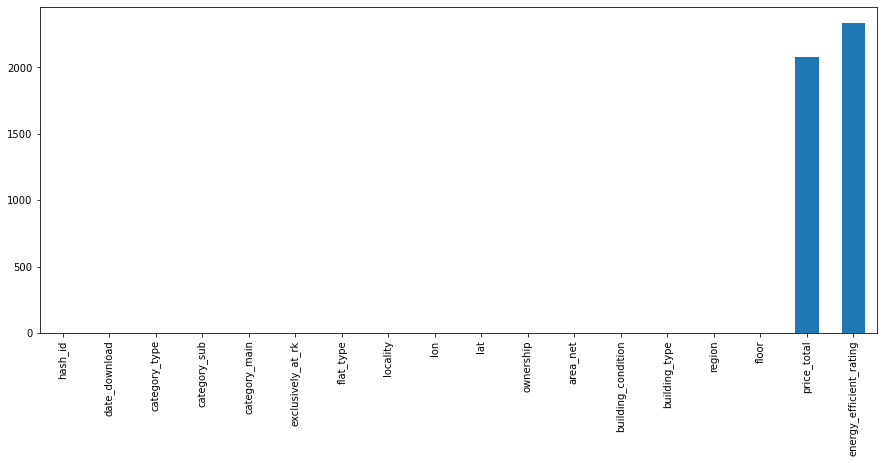

In [222]:
df.isna().sum().sort_values().plot.bar(figsize=(15, 6))

Next, we deal with the rest:

In [223]:
# 'energy_efficient_rating' -> fill with mode
df['energy_efficient_rating'].value_counts()

G    8731
B    4103
C    3576
D    1382
E     426
A     277
F     146
Name: energy_efficient_rating, dtype: int64

In [224]:
df['energy_efficient_rating'].fillna(df['energy_efficient_rating'].mode()[0], inplace = True)

In [225]:
# "floor" --> 1 NaN --> drop
df = df.dropna(subset=["floor"], axis=0)

In [226]:
df.shape

(20978, 18)

In [227]:
# 'price_toal' -> simply drop NaN rows
#df["price_total"].dropna(inplace=True)  -->  not working
df = df.dropna(subset=["price_total"], axis=0)

In [228]:
df.shape

(18901, 18)

<AxesSubplot:>

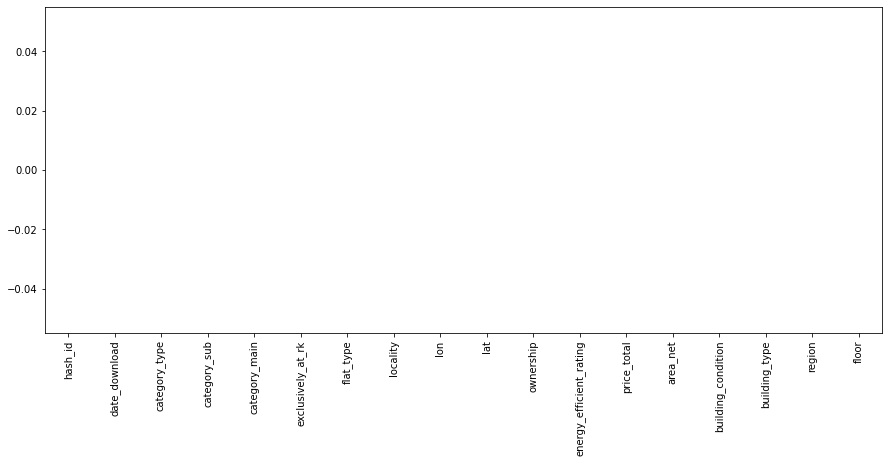

In [229]:
# Check
df.isna().sum().sort_values().plot.bar(figsize=(15, 6))

## **Analyzing data**

In [230]:
df.describe()

,hash_id,area_net,price_total,lat,lon,exclusively_at_rk,category_main,category_sub,category_type,floor
count,1.890100e+04,18901.000000,1.890100e+04,18901.000000,18901.000000,18901.000000,18901.0,18901.000000,18901.0,18901.000000
mean,2.143400e+09,66.421618,5.073873e+06,49.918811,15.150319,0.423787,1.0,5.355219,1.0,3.234802
std,1.235393e+09,24.616845,3.399364e+06,0.469746,1.539334,0.494171,0.0,2.011805,0.0,2.162865
min,6.383600e+04,25.000000,8.000000e+05,48.589103,12.177395,0.000000,1.0,2.000000,1.0,0.000000
25%,1.081988e+09,50.000000,2.690000e+06,49.664540,14.284062,0.000000,1.0,4.000000,1.0,2.000000
50%,2.134670e+09,63.000000,4.190000e+06,50.039193,14.519216,0.000000,1.0,5.000000,1.0,3.000000
75%,3.208631e+09,78.000000,6.500000e+06,50.152035,16.447502,1.000000,1.0,7.000000,1.0,4.000000
max,4.294956e+09,182.000000,2.101162e+07,50.993186,18.831846,1.000000,1.0,16.000000,1.0,12.000000


#### Particular columns:

##### *Area_net*

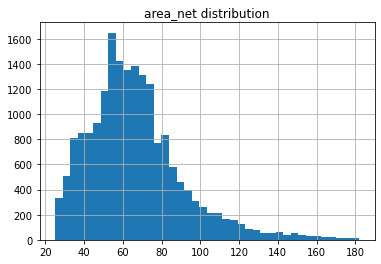

In [231]:
#plt.figure(figsize = (10,7))
df["area_net"].hist(bins=40)
plt.title("area_net" + " distribution")
plt.show()

We create a **new variable "flat_size"** from "area_net" column: (to categorize area variable)

In [232]:
df["flat_size"] = pd.cut(df["area_net"], bins = [0,50,110,200], labels = ['small','medium','large'])

We do some columns exploration so we know what values are in our dataset:

##### *FLat_size*

<AxesSubplot:>

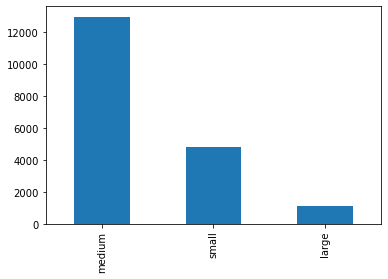

In [233]:
df["flat_size"].value_counts().plot(kind="bar") #normalize=True sort=True

##### *Floor*

In [234]:
df["floor"].dtype

dtype('float64')

In [235]:
df = df.astype({"floor": object})

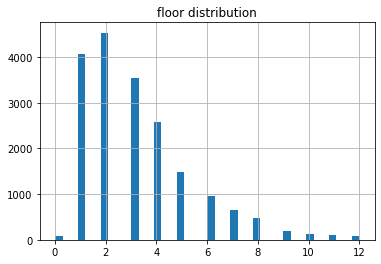

In [236]:
#plt.figure(figsize = (10,7))
df["floor"].hist(bins=40)
plt.title("floor" + " distribution")
plt.show()

<AxesSubplot:>

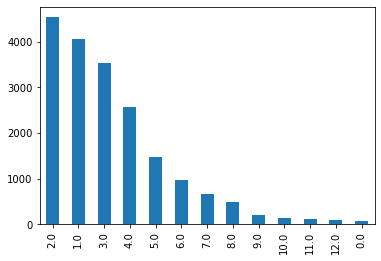

In [237]:
df["floor"].value_counts().plot(kind="bar")

##### *Region/Locality*

<AxesSubplot:>

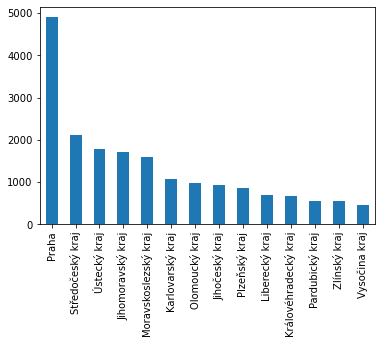

In [238]:
df.region.value_counts().plot(kind="bar") #normalize=True sort=True

In [239]:
df.locality.value_counts() # More detailed

Praha 3 - Žižkov                      316
Most                                  311
Karlovy Vary                          235
Praha 5 - Smíchov                     207
Praha 5 - Stodůlky                    201
                                     ... 
Zvole, okres Šumperk                    1
Dřevohostice, okres Přerov              1
Vidnava, okres Jeseník                  1
Hradec nad Svitavou, okres Svitavy      1
Buřenice, okres Pelhřimov               1
Name: locality, Length: 1853, dtype: int64

##### *Building_type*

<AxesSubplot:>

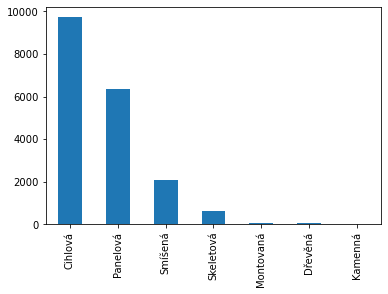

In [240]:
df.building_type.value_counts().plot(kind="bar")

##### *Building_condition*

<AxesSubplot:>

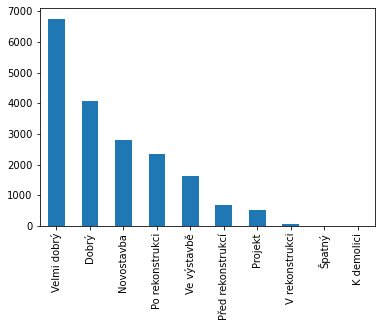

In [241]:
df.building_condition.value_counts().plot(kind="bar")

##### *Enerygy_efficient_rating*

<AxesSubplot:>

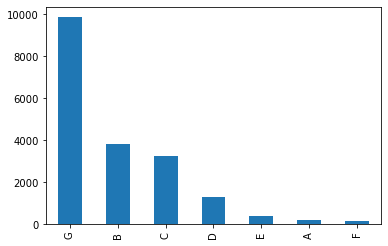

In [242]:
df.energy_efficient_rating.value_counts().plot(kind="bar")

##### *Ownership*

<AxesSubplot:>

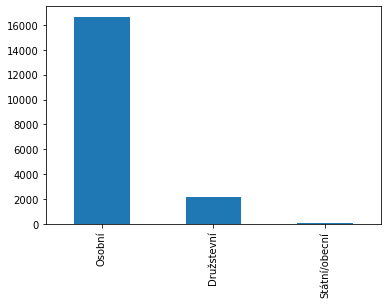

In [243]:
df.ownership.value_counts().plot(kind="bar")

##### *Exlusively_at_rk* - 1 if the estate is being sold by real estate company; 0 otherwise

<AxesSubplot:>

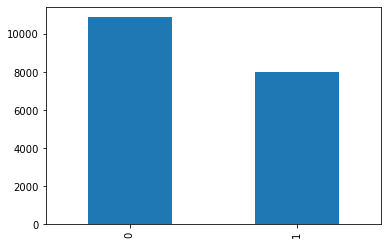

In [244]:
df.exclusively_at_rk.value_counts().plot(kind="bar")

##### *Flat_type*

<AxesSubplot:>

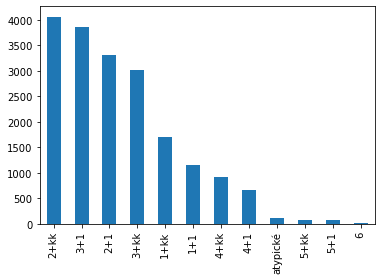

In [245]:
df.flat_type.value_counts().plot(kind="bar")

Next ,we can look if the distribution of flat_size is similar in every region:

Praha:


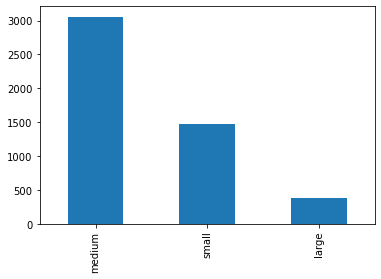

Moravskoslezský kraj:


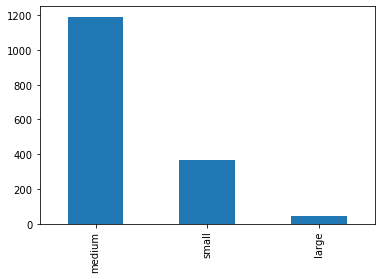

In [246]:
regions = ["Praha", "Moravskoslezský kraj"] # Add which you are insterested in
for region in regions:
    print(region, ":", sep = "")  
    df[df.region == region]["flat_size"].value_counts().plot(kind="bar")
    plt.show()
del regions

In [247]:
df[["region","flat_size"]].value_counts(sort=False) #normalize=True sort=True

region                flat_size
Jihomoravský kraj     small         453
                      medium       1140
                      large         130
Jihočeský kraj        small         195
                      medium        680
                      large          66
Karlovarský kraj      small         190
                      medium        784
                      large          98
Královéhradecký kraj  small         172
                      medium        479
                      large          30
Liberecký kraj        small         188
                      medium        473
                      large          33
Moravskoslezský kraj  small         368
                      medium       1191
                      large          45
Olomoucký kraj        small         267
                      medium        665
                      large          35
Pardubický kraj       small         121
                      medium        417
                      large          22
Plzeňský

### **Price Analysis:**

For example, we can also look at the price distribution of different size of flats in the Czech Republic.

small:


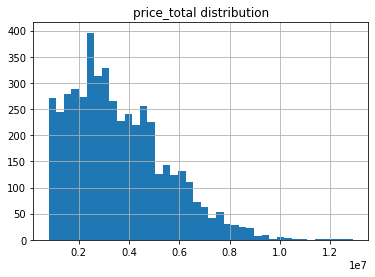

medium:


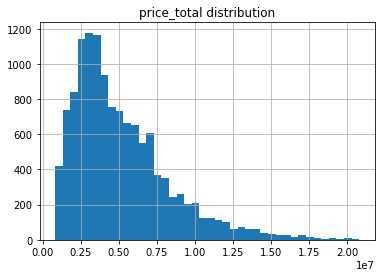

large:


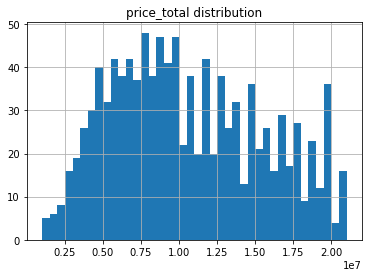

In [248]:
sizes = ["small", "medium", "large"]
for size in sizes:
    print(size, ":", sep = "")  
    df[df.flat_size == size]["price_total"].hist(bins=40)
    plt.title("price_total" + " distribution")
    plt.show()
del sizes

We can look at medium price in different groups:

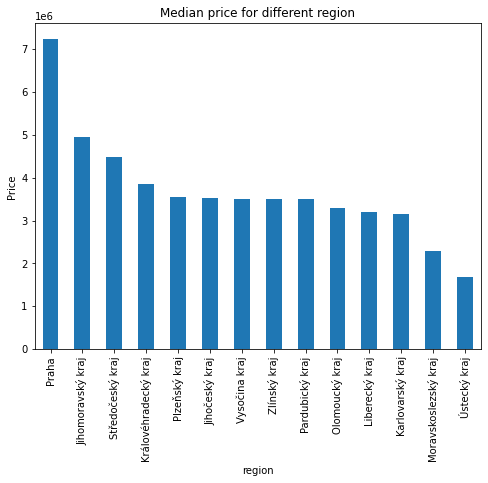

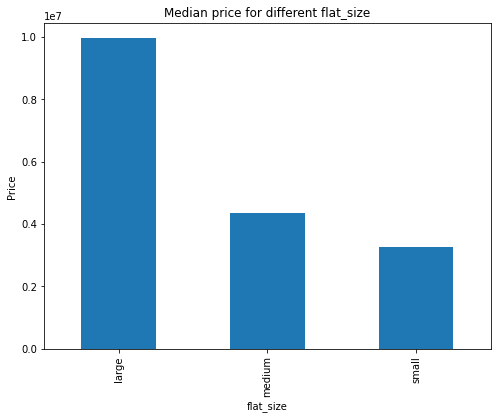

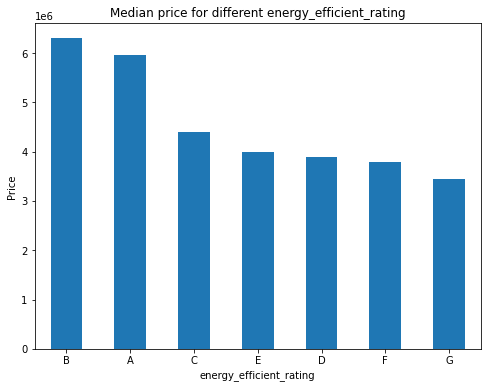

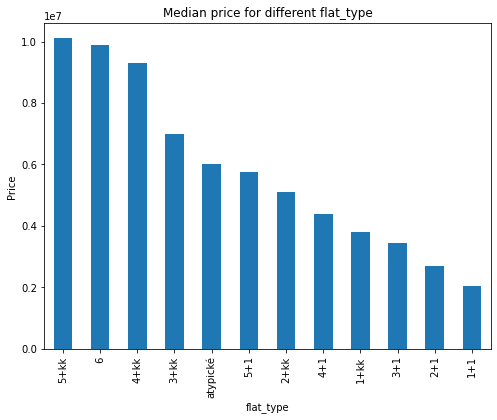

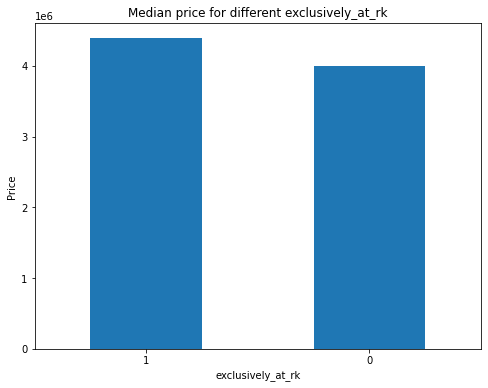

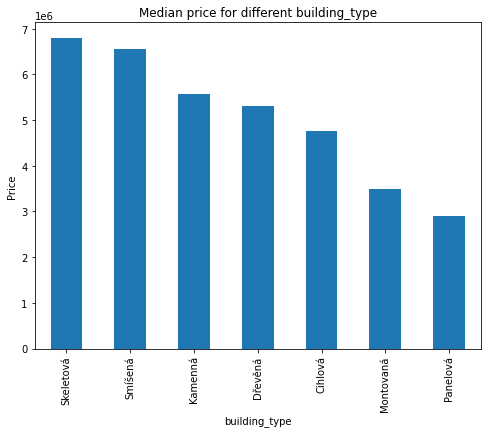

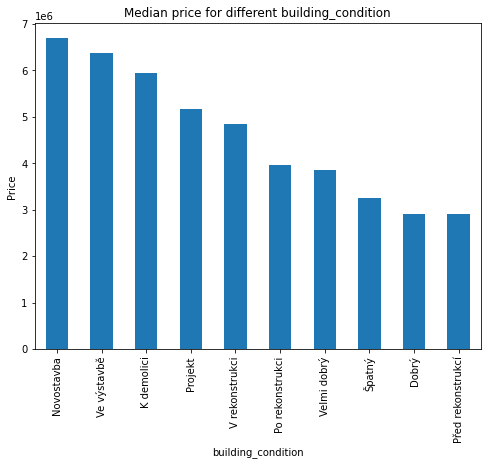

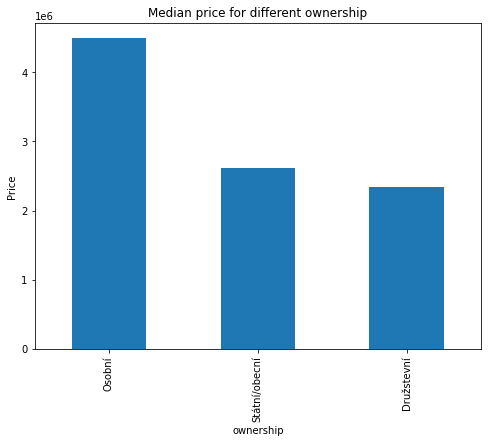

In [249]:
columns = ["region", "flat_size", "energy_efficient_rating", "flat_type", "exclusively_at_rk", "building_type", "building_condition", "ownership"]
for col in columns:
    df.groupby([col])["price_total"].median().sort_values(ascending = False).plot(kind="bar", figsize = (8,6)) #mean(), color=['orange','blue', 'red', 'green', 'yellow'
    plt.xlabel(col)
    plt.ylabel("Price")
    if col in ["energy_efficient_rating", "exclusively_at_rk"]:
        plt.xticks(rotation=0)
    plt.title("Median price for different " + col)
    plt.show()    
del columns   

We can look at median price even for 2 combinations of variables:

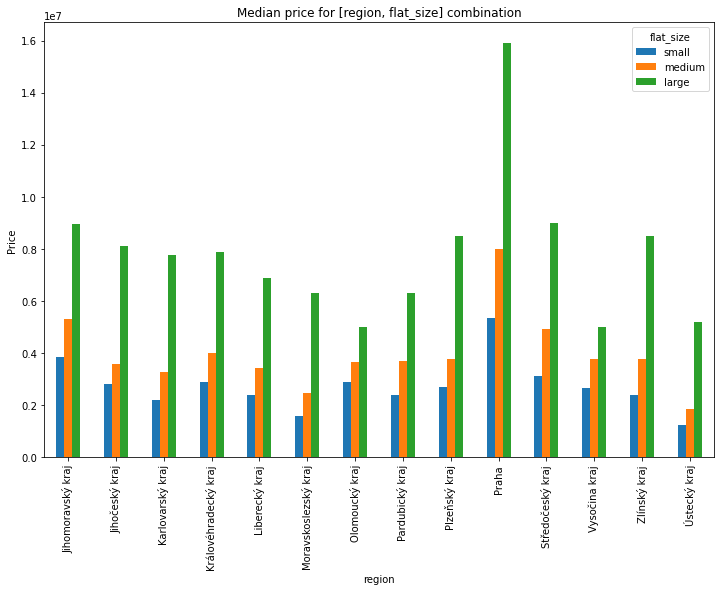

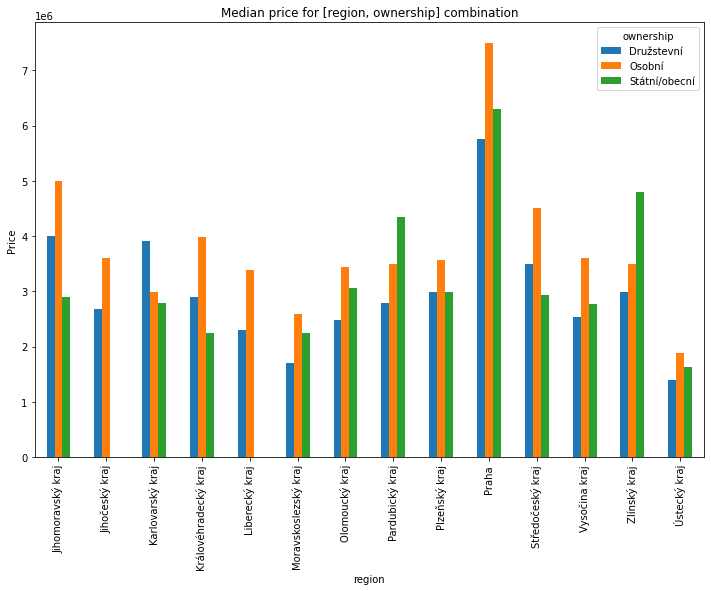

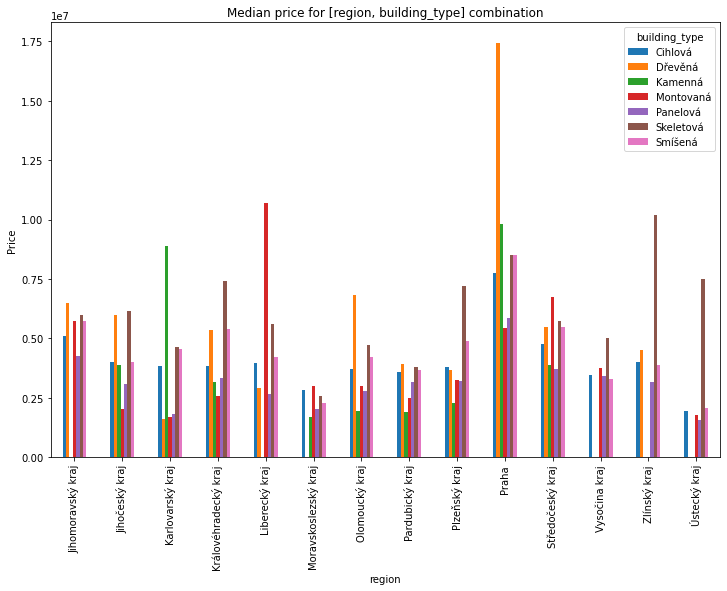

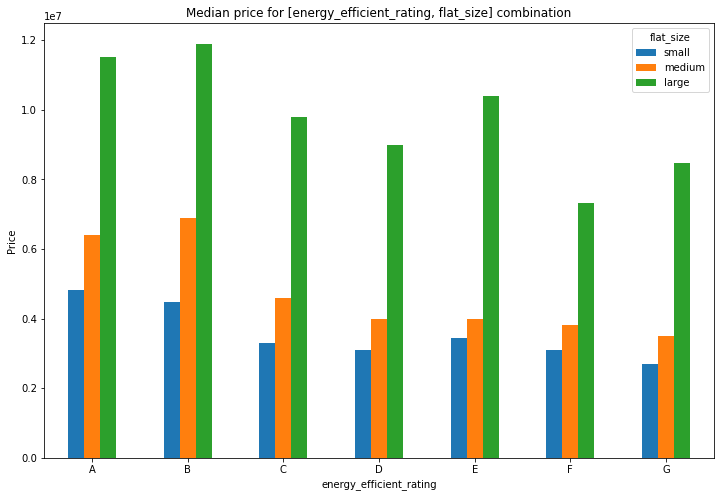

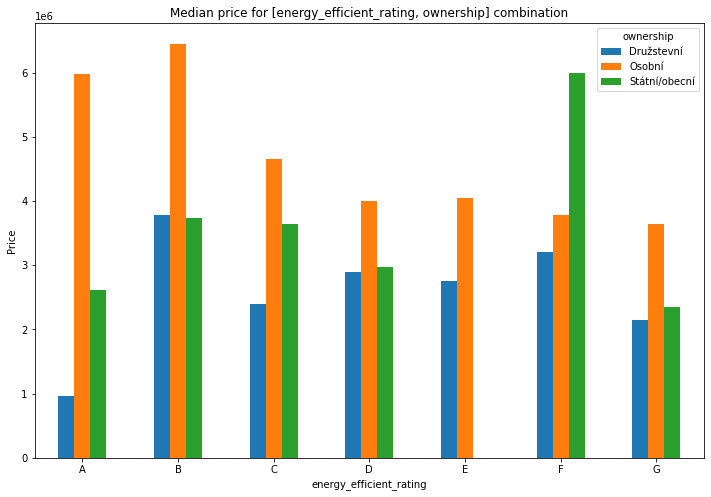

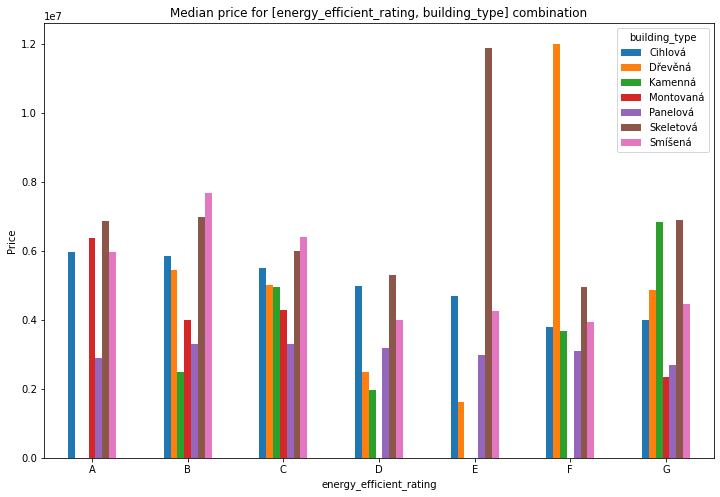

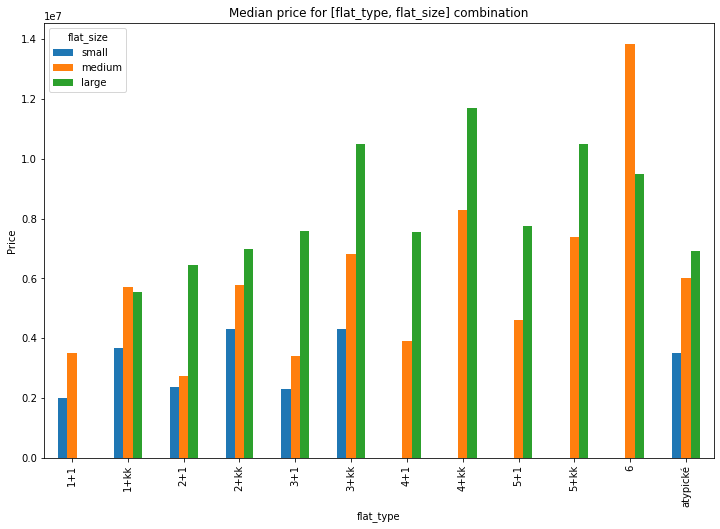

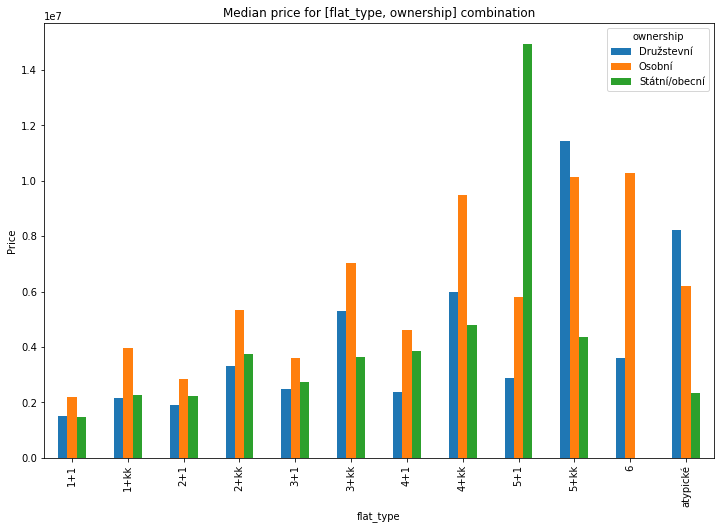

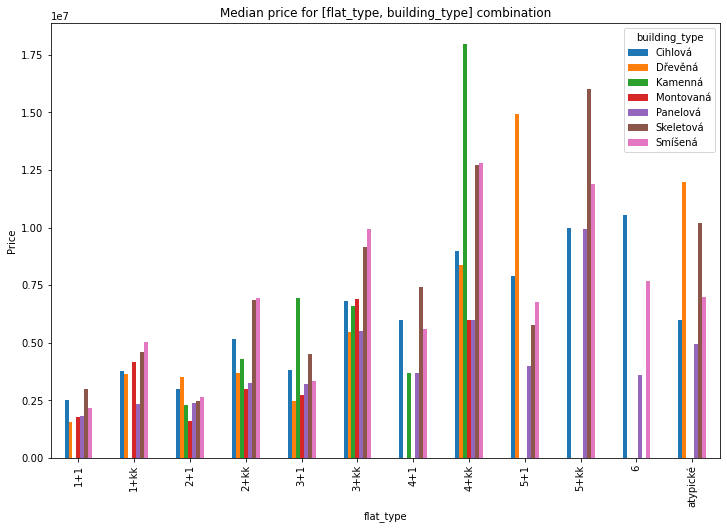

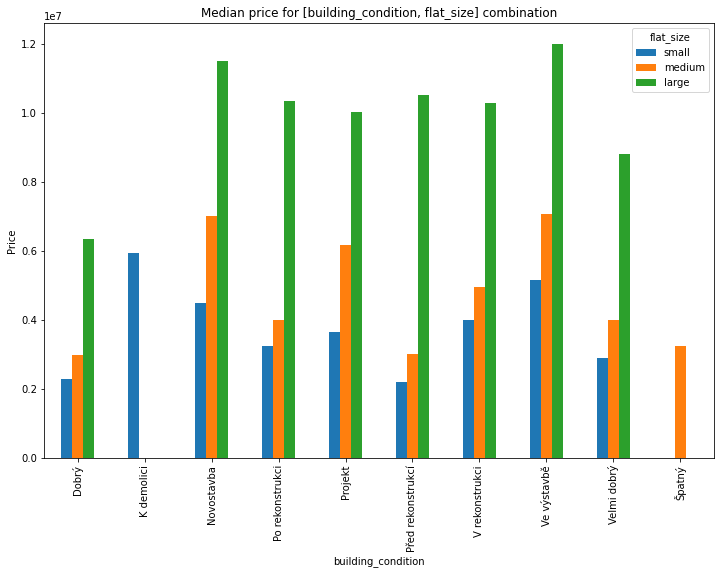

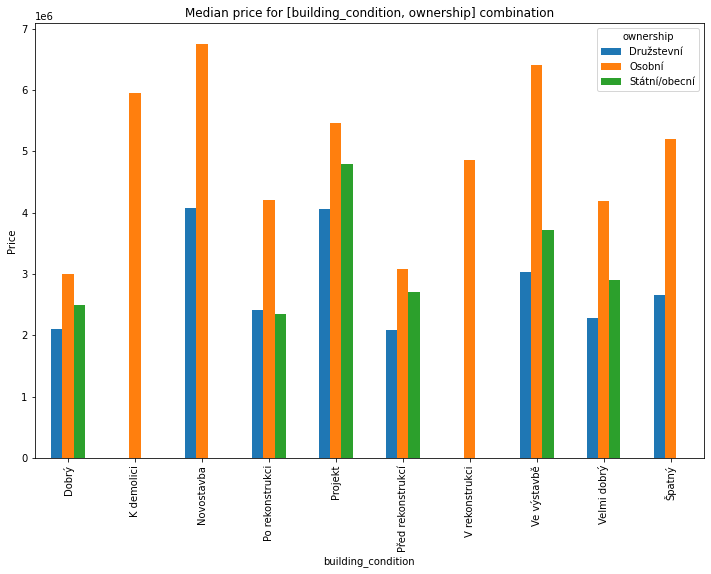

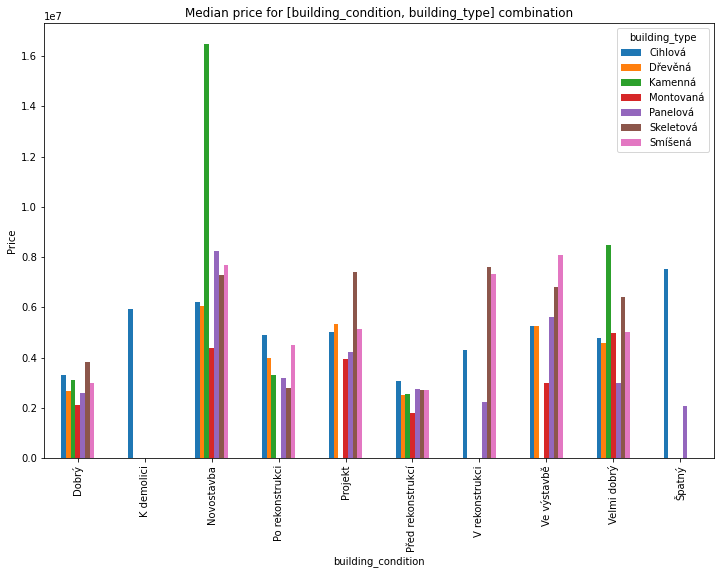

In [250]:
columns_plenty_values = ["region", "energy_efficient_rating", "flat_type", "building_condition"]
columns_few_values = ["flat_size", "ownership", "building_type"]
for col1 in columns_plenty_values:
    for col2 in columns_few_values:
        pd.pivot_table(df, values="price_total", index=col1, columns=col2, aggfunc='median').plot(kind = "bar", figsize = (12,8)) # aggfunc='mean'
        plt.ylabel(col1)
        if col1 in ["energy_efficient_rating"]:
            plt.xticks(rotation=0)
        plt.ylabel("Price")
        plt.title(f"Median price for [{col1}, {col2}] combination")
        plt.show()
del columns_plenty_values
del columns_few_values

Correlation:

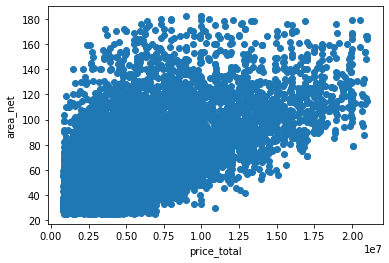

In [251]:
# Scatter plot:
plt.scatter(df['price_total'],df['area_net'])
plt.xlabel('price_total')
plt.ylabel('area_net')
plt.show()

In [252]:
df = df.astype({"floor": np.int64})
df[["price_total", "area_net", "floor"]].corr()

,price_total,area_net,floor
price_total,1.000000,0.542801,0.027274
area_net,0.542801,1.000000,-0.046037
floor,0.027274,-0.046037,1.000000
